In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb



In [2]:
df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")

C:\Users\Woj-tek\AppData\Local\Temp\ipykernel_111408\713402779.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")


In [3]:
# z kolumny 'Event.Date' wyciągamy do osobnych kolumn rok, miesiąc i dzień
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# z kolumny 'Location' wyciągamy do osbnych kolumn miasto i stan
df['City'] = df['Location'].str.split(',').str[0]
df['State'] = df['Location'].str.split(',').str[1]

# 'Unk' i 'UNK' zamieniamy na jedną wartość 'Unknown'
df['Weather.Condition'].replace(to_replace = ['Unk', 'UNK'], value = 'Unknown', inplace = True)

# wartości np. Fatal(1), Fatal(123) zamieniamy na jedną wartość 'Fatal'
df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')

# puste wartości uzupełniamy najczęściej występującymi wartościami w danej kolumnie
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna(df['Purpose.of.flight'].mode()[0])
df['Weather.Condition'] = df['Weather.Condition'].fillna(df['Weather.Condition'].mode()[0])
df['Engine.Type'] = df['Engine.Type'].fillna(df['Engine.Type'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])

# w kolumnie number.of.Engines średnia oraz mediana jest podabna, wiec uzupełniam puste wartosci medianą
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

C:\Users\Woj-tek\AppData\Local\Temp\ipykernel_111408\850482051.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')


In [4]:
# poniższy kod zamienia wszystkie wartości NaN na 'Unavailable' albo 'Unknown' dla kolumn gdzie już takie wartości występują. 
# Dzięki temu po późniejszym zastosowaniu df.dropna() zamiast 50k rekordów zostaje aż 77k. 
# Pytanie tylko czy wartości 'Unknown' w modelu mają jakikolwiek sens i czy nie lepiej faktycznie zredukować dane do tych 50k.
'''
df['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')
df['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')
df['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')
df['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')
df['Make'] = df['Make'].fillna('Unknown')
'''

"\ndf['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')\ndf['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')\ndf['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')\ndf['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')\ndf['Make'] = df['Make'].fillna('Unknown')\n"

In [5]:
df = df.dropna()

In [6]:
df.columns

Index(['Event.Id', 'Investigation.Type', 'Event.Date', 'Location',
       'Injury.Severity', 'Aircraft.damage', 'Make', 'Model',
       'Number.of.Engines', 'Engine.Type', 'Purpose.of.flight',
       'Total.Fatal.Injuries', 'Weather.Condition', 'Broad.phase.of.flight',
       'Year', 'Month', 'Day', 'City', 'State'],
      dtype='object')

In [7]:
df = df[['Number.of.Engines', 'Engine.Type', 'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight','Month']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49498 entries, 0 to 63909
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Number.of.Engines      49498 non-null  float64
 1   Engine.Type            49498 non-null  object 
 2   Purpose.of.flight      49498 non-null  object 
 3   Weather.Condition      49498 non-null  object 
 4   Broad.phase.of.flight  49498 non-null  object 
 5   Month                  49498 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.6+ MB


In [9]:
df.groupby('Broad.phase.of.flight')['Number.of.Engines'].agg(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
Broad.phase.of.flight,,,,,
Approach,5415,0.0,4.0,1.189104,6439.0
Climb,1649,0.0,4.0,1.220740,2013.0
Cruise,8391,0.0,4.0,1.121201,9408.0
Descent,1454,0.0,4.0,1.154746,1679.0
Go-around,1116,1.0,4.0,1.147849,1281.0
Landing,11614,0.0,4.0,1.132512,13153.0
Maneuvering,7104,0.0,4.0,1.043215,7411.0
Other,96,0.0,4.0,1.125000,108.0
Standing,553,0.0,4.0,1.339964,741.0


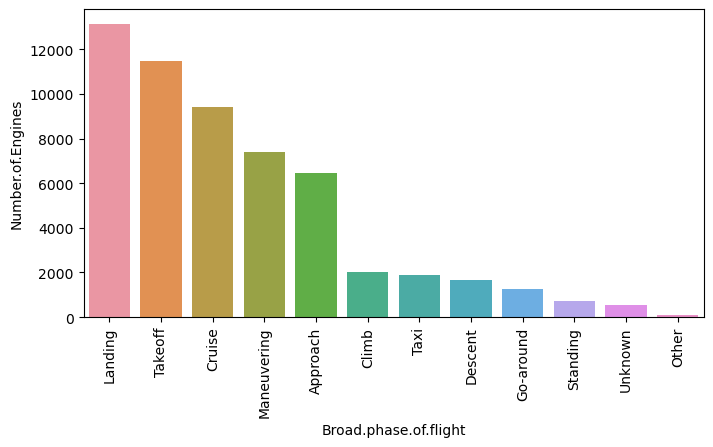

In [10]:
phase_flight_grouped= df.groupby("Broad.phase.of.flight").sum('Number.of.Engines').reset_index().sort_values(by='Number.of.Engines',ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data = phase_flight_grouped, x = phase_flight_grouped['Broad.phase.of.flight'],y= phase_flight_grouped['Number.of.Engines'], estimator = sum)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8,4))
df['State'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("State", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 States", size=20)
plt.show()

plt.figure(figsize=(8,4))
df['Make'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("Make", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 Plane Makes", size=20)
plt.show()

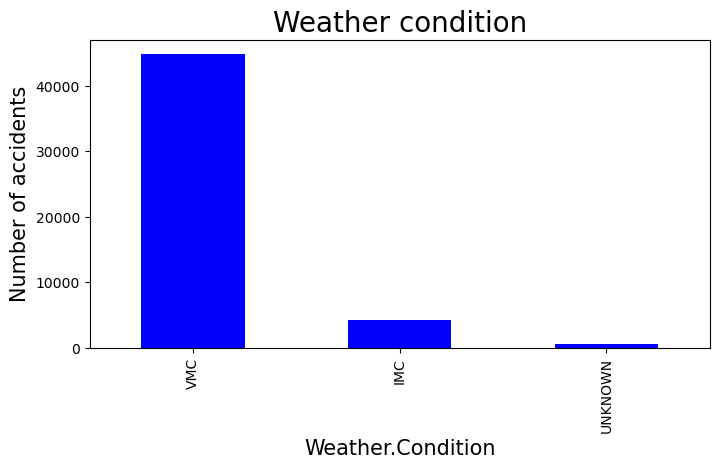

In [11]:
plt.figure(figsize=(8,4))
df['Weather.Condition'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xlabel("Weather.Condition", size=15)
plt.ylabel("Number of accidents", size=15)
plt.title("Weather condition", size=20)
plt.show()

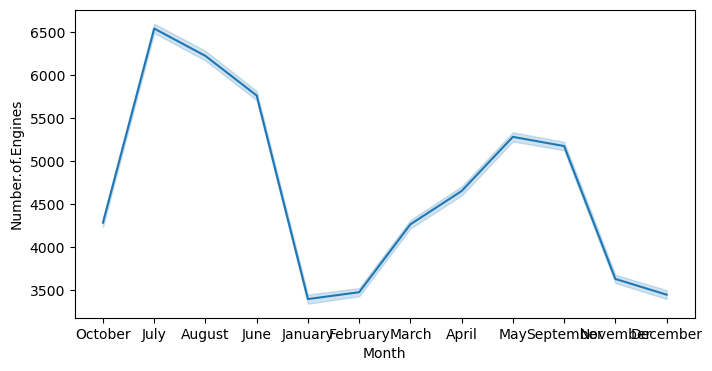

In [12]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = df, x = df['Month'], y= df['Number.of.Engines'],estimator=sum)
plt.show()

In [13]:
#sns.barplot(data=df,x='Weather.Condition',y='Total.Fatal.Injuries',estimator=sum)

In [14]:
#sns.barplot(data = df,x=df['Purpose.of.flight'],y=df['Total.Fatal.Injuries'],estimator=sum)
#plt.xticks(rotation=90);

In [15]:
df.describe()

,Number.of.Engines
count,49498.000000
mean,1.134470
std,0.410456
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000


In [16]:
df = df.reset_index()

___

In [17]:
#df['Total.Fatal.Injuries_encoded'] = df['Total.Fatal.Injuries'].where(df['Total.Fatal.Injuries'] ==0, other=1)

In [18]:
df_X = df[['Number.of.Engines', 'Engine.Type', 'Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight','Month']]

In [19]:
lista_kolumn_X = list(df_X.columns)

for i in lista_kolumn_X:
    print(i, df_X[i].value_counts().count())

Number.of.Engines 5
Engine.Type 6
Purpose.of.flight 21
Weather.Condition 3
Broad.phase.of.flight 12
Month 12


In [20]:
df_X_get_dummies = pd.get_dummies(df_X)

In [21]:
df_X_get_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49498 entries, 0 to 49497
Data columns (total 55 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Number.of.Engines                            49498 non-null  float64
 1   Engine.Type_Reciprocating                    49498 non-null  uint8  
 2   Engine.Type_Turbo Fan                        49498 non-null  uint8  
 3   Engine.Type_Turbo Jet                        49498 non-null  uint8  
 4   Engine.Type_Turbo Prop                       49498 non-null  uint8  
 5   Engine.Type_Turbo Shaft                      49498 non-null  uint8  
 6   Engine.Type_Unknown                          49498 non-null  uint8  
 7   Purpose.of.flight_Aerial Application         49498 non-null  uint8  
 8   Purpose.of.flight_Aerial Observation         49498 non-null  uint8  
 9   Purpose.of.flight_Air Drop                   49498 non-null  uint8  
 10

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
# Utworzenie obiektu klasy StandardScaler 
#scaler = StandardScaler()

In [25]:
#scaler.fit(X_train)

In [26]:
#[scaler.mean_, scaler.var_]

In [39]:
import xgboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree


In [60]:
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plot

In [61]:
#xgb_reg.fit(X_train, y_train)

In [62]:
#y_pred = xgb_reg.predict(X_test)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df_X_get_dummies['Number.of.Engines'], test_size=0.3,random_state=123)

In [98]:
xgb_clf = XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=100)

In [99]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34648, 55)
(14850, 55)
(34648,)
(14850,)


In [100]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [101]:
y_predict = xgb_clf.predict(X_test)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [104]:
pred_train = xgb_clf.predict(X_train)
pred_test = xgb_clf.predict(X_test)

In [105]:
confusion_matrix(y_test, y_predict)

array([[  142,     0,     0,     0,     0],
       [    0, 12740,     0,     0,     0],
       [    0,     0,  1837,     0,     0],
       [    0,     0,     0,    62,     0],
       [    0,     0,     0,     0,    69]], dtype=int64)

In [106]:
confusion_matrix(y_train,pred_train)

array([[  320,     0,     0,     0,     0],
       [    0, 29809,     0,     0,     0],
       [    0,     0,  4215,     0,     0],
       [    0,     0,     0,   177,     0],
       [    0,     0,     0,     0,   127]], dtype=int64)

In [107]:
print(classification_report(y_train,pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       320
         1.0       1.00      1.00      1.00     29809
         2.0       1.00      1.00      1.00      4215
         3.0       1.00      1.00      1.00       177
         4.0       1.00      1.00      1.00       127

    accuracy                           1.00     34648
   macro avg       1.00      1.00      1.00     34648
weighted avg       1.00      1.00      1.00     34648



In [108]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       142
         1.0       1.00      1.00      1.00     12740
         2.0       1.00      1.00      1.00      1837
         3.0       1.00      1.00      1.00        62
         4.0       1.00      1.00      1.00        69

    accuracy                           1.00     14850
   macro avg       1.00      1.00      1.00     14850
weighted avg       1.00      1.00      1.00     14850

